# Logistic classification with cross-entropy

This tutorial will cover how to model a binary classification problem with the help of the [logistic function](#Logistic-function) and the [cross-entropy](#Cross-entropy-loss-function-for-the-logistic-function) loss function.

To output discrete classes with neural networks, we can model a probability distribution over the output classes $t$. For the classification of 2 classes $t=1$ or $t=0$ we can use the [logistic function](http://en.wikipedia.org/wiki/Logistic_function) used in [logistic regression](http://en.wikipedia.org/wiki/Logistic_regression). For multiclass classification there exists an extension of this logistic function called the [softmax function](http://en.wikipedia.org/wiki/Softmax_function), which is used in [multinomial logistic regression](http://en.wikipedia.org/wiki/Multinomial_logistic_regression). The [following section]({% post_url 2015-06-10-cross-entropy-softmax %}) will explain the softmax function and how to derive it. What follows here will explain the logistic function and how to optimize it.

This is the first part of a 2-part tutorial on classification models trained by cross-entropy:
- [Part 1: Logistic classification with cross-entropy (this)]({% post_url 2015-06-10-cross-entropy-logistic %})
- [Part 2: Softmax classification with cross-entropy]({% post_url 2015-06-10-cross-entropy-softmax %})

In [1]:
# Python imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Fancier plots

# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')
#

## Logistic function

The goal is to predict the target class $t$ from an input $z$. The probability $P(t=1 | z)$ that input $z$ is classified as class $t=1$ is represented by the output $y$ of the logistic function computed as $y = \sigma(z)$. The [logistic function](http://en.wikipedia.org/wiki/Logistic_function) $\sigma$ is defined as:
$$ \sigma(z) = \frac{1}{1+e^{-z}} $$

This logistic function, implemented below as `logistic(z)`, maps the input $z$ to an output between $0$ and $1$ as is illustrated in the figure below.

We can write the probabilities that the class is $t=1$ or $t=0$ given input $z$ as:

$$\begin{split}
P(t=1| z) & = \sigma(z) = \frac{1}{1+e^{-z}} \\
P(t=0| z) & = 1 - \sigma(z) = \frac{e^{-z}}{1+e^{-z}} 
\end{split}$$

Note that input $z$ to the logistic function corresponds to the log [odds ratio](https://en.wikipedia.org/wiki/Odds_ratio) of $P(t=1|z)$ over $P(t=0|z)$.

$$\begin{split}
\log \frac{P(t=1|z)}{P(t=0|z)} & = \log \frac{\frac{1}{1+e^{-z}}}{\frac{e^{-z}}{1+e^{-z}}} = \log \frac{1}{e^{-z}} \\
& = \log(1) - \log(e^{-z}) = z
\end{split}$$

This means that the log-odds $\log(P(t=1|z)/P(t=0|z))$ changes linearly with $z$. If $z = x \cdot w$, as in a typical neural network linear layer, then as a result, the log-odds will change linearly with the parameters $w$ and input samples $x$.

In [2]:
def logistic(z):
    """Logistic function."""
    return 1 / (1 + np.exp(-z))

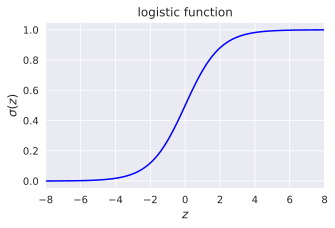

In [3]:
# Plot the logistic function
z = np.linspace(-8, 8, 100)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(z, logistic(z), 'b-')
ax.set_xlabel('$z$', fontsize=12)
ax.set_ylabel('$\sigma(z)$', fontsize=12)
ax.set_title('logistic function')
ax.set_xlim(-8, 8)
plt.show()
#

### Derivative of the logistic function

Since neural networks typically use [gradient](http://en.wikipedia.org/wiki/Gradient) based opimization techniques such as [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) it is important to define the [derivative](http://en.wikipedia.org/wiki/Derivative) of the output $y$ of the logistic function with respect to its input $z$. ${\partial y}/{\partial z}$ can be calculated as:

$$
\frac{\partial y}{\partial z} = \frac{\partial \sigma(z)}{\partial z} 
= \frac{\partial \frac{1}{1+e^{-z}}}{\partial z} 
= \frac{-1}{(1+e^{-z})^2} \cdot e^{-z} \cdot -1 
= \frac{1}{1+e^{-z}} \frac{e^{-z}}{1+e^{-z}}
$$

And since $1 - \sigma(z)) = 1 - {1}/(1+e^{-z}) = {e^{-z}}/(1+e^{-z})$ this can be rewritten as:

$$
\frac{\partial y}{\partial z} 
= \frac{1}{1+e^{-z}} \frac{e^{-z}}{1+e^{-z}} 
= \sigma(z) \cdot (1- \sigma(z)) =  y (1-y)
$$

This derivative is implemented as `logistic_derivative(z)` and is plotted below.

In [4]:
def logistic_derivative(z):
    """Derivative of the logistic function."""
    return logistic(z) * (1 - logistic(z))

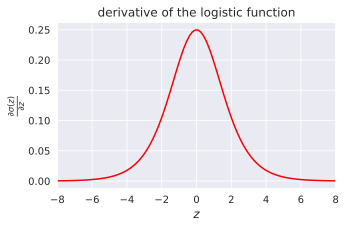

In [5]:
# Plot the derivative of the logistic function
z = np.linspace(-8, 8, 100)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(z, logistic_derivative(z), 'r-')
ax.set_xlabel('$z$', fontsize=12)
ax.set_ylabel('$\\frac{\\partial \\sigma(z)}{\\partial z}$', fontsize=12)
ax.set_title('derivative of the logistic function')
ax.set_xlim(-8, 8)
plt.show()
#

### Cross-entropy loss function for the logistic function

The output of the model $y = \sigma(z)$ can be interpreted as a probability $y$ that input $z$ belongs to one class $(t=1)$, or probability $1-y$ that $z$ belongs to the other class $(t=0)$ in a two class classification problem. We note this down as: $P(t=1| z) = \sigma(z) = y$.

The neural network model will be optimized by maximizing the [likelihood](http://en.wikipedia.org/wiki/Likelihood_function) that a given set of parameters $\theta$ of the model can result in a prediction of the correct class of each input sample. The parameters $\theta$ transform each input sample $i$ into an input to the logistic function $z_{i}$. The likelihood maximization can be written as:

$$
\underset{\theta}{\text{argmax}}\; \mathcal{L}(\theta|t,z) = \underset{\theta}{\text{argmax}} \prod_{i=1}^{n} \mathcal{L}(\theta|t_i,z_i)
$$

The likelihood $\mathcal{L}(\theta|t,z)$ can be rewritten as the [joint probability](http://en.wikipedia.org/wiki/Joint_probability_distribution) of generating $t$ and $z$ given the parameters $\theta$: $P(t,z|\theta)$. Since $P(A,B) = P(A|B)P(B)$ this can be written as:

$$
P(t,z|\theta) = P(t|z,\theta)P(z|\theta)
$$

Since we are not interested in the probability of $z$ we can reduce this to: $\mathcal{L}(\theta|t,z) = P(t|z,\theta) = \prod_{i=1}^{n} P(t_i|z_i,\theta)$. 
Since $t_i$ is a [Bernoulli variable](http://en.wikipedia.org/wiki/Bernoulli_distribution), and the probability $P(t| z) = y$ is fixed for a given $\theta$ we can rewrite this as: 

$$
\begin{split}
P(t|z) & = \prod_{i=1}^{n} P(t_i=1|z_i)^{t_i} \cdot (1 - P(t_i=1|z_i))^{1-t_i} \\
& = \prod_{i=1}^{n} y_i^{t_i} \cdot (1 - y_i)^{1-t_i} \end{split}
$$

Since the logarithmic function is a monotone increasing function we can optimize the log-likelihood function $\underset{\theta}{\text{argmax}}\; \log \mathcal{L}(\theta|t,z)$. This maximum will be the same as the maximum from the regular likelihood function. The benefit of using the log-likelihood is that it can prevent numerical [underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow) when the probabilities are low. The log-likelihood function can be written as:

$$
\begin{split} \log \mathcal{L}(\theta|t,z) & = \log \prod_{i=1}^{n} y_i^{t_i} \cdot (1 - y_i)^{1-t_i} \\
& = \sum_{i=1}^{n} t_i \log(y_i) + (1-t_i) \log(1 - y_i)
\end{split}
$$

Minimizing the negative of this function (minimizing the negative log likelihood) corresponds to maximizing the likelihood. This error function $\xi(t,y)$ is typically known as the [cross-entropy error function](http://en.wikipedia.org/wiki/Cross_entropy) (also known as log-loss):

$$
\begin{split}
\xi(t,y) & = - \log \mathcal{L}(\theta|t,z) \\
& = - \sum_{i=1}^{n} \left[ t_i \log(y_i) + (1-t_i)\log(1-y_i) \right] \\
& = - \sum_{i=1}^{n} \left[ t_i \log(\sigma(z)) + (1-t_i)\log(1-\sigma(z)) \right]
\end{split}
$$

This function looks complicated but besides the previous derivation there are a couple of intuitions why this function is used as a [loss function](https://en.wikipedia.org/wiki/Loss_function) for logistic regression. First of all it can be rewritten as:

$$
\xi(t_i,y_i) = 
\begin{cases}
    -\log(y_i) & \text{if } t_i = 1 \\
    -\log(1-y_i) & \text{if } t_i = 0
\end{cases}
$$
  
Which in the case of $t_i=1$ is $0$ if $y_i=1$ $(-\log(1)=0)$ and goes to infinity as $y_i \rightarrow 0$ $(\underset{y \rightarrow 0}{\text{lim}}{(-\log(y))} = +\infty)$. The reverse effect is happening if $t_i=0$.  
So what we end up with is a loss function that is $0$ if the probability to predict the correct class is $1$ and goes to infinity as the probability to predict the correct class goes to $0$.

Notice that the loss function $\xi(t,y)$ is equal to the negative [log probability](http://en.wikipedia.org/wiki/Log_probability) that $z$ is classified as its correct class:  
$$
\begin{split}
-\log(P(t=1| z)) &= -\log(y) \\  
-\log(P(t=0| z)) &= -\log(1-y)
\end{split}
$$

By minimizing the negative log probability, we will maximize the log probability. And since $t$ can only be $0$ or $1$, we can write $\xi(t,y)$ as:

$$
\xi(t,y) = -t \log(y) - (1-t) \log(1-y)
$$

Which will give $\xi(t,y) = - \sum_{i=1}^{n} \left[ t_i \log(y_i) + (1-t_i)\log(1-y_i) \right]$ if we sum over all $n$ samples.


Another reason to use the cross-entropy function is that in simple logistic regression this results in a [convex](http://en.wikipedia.org/wiki/Convex_function) loss function, of which the global minimum will be easy to find. Note that this is not necessarily the case anymore in multilayer neural networks.

#### Derivative of the cross-entropy loss function for the logistic function

The derivative ${\partial \xi}/{\partial y}$ of the loss function with respect to its input can be calculated as:

$$
\begin{split}
\frac{\partial \xi}{\partial y} 
&= \frac{\partial (-t \log(y) - (1-t) \log(1-y))}{\partial y} 
= \frac{\partial (-t \log(y))}{\partial y} +  \frac{\partial (- (1-t)  \log(1-y))}{\partial y} \\
& = -\frac{t}{y} + \frac{1-t}{1-y} = \frac{y-t}{y(1-y)}
\end{split}
$$

This derivative will give a nice formula if it is used to calculate the derivative of the loss function with respect to the inputs of the classifier ${\partial \xi}/{\partial z}$ since the derivative of the logistic function is ${\partial y}/{\partial z} =  y (1-y)$:

$$
\frac{\partial \xi}{\partial z} = \frac{\partial y}{\partial z} \frac{\partial \xi}{\partial y} = y (1-y) \frac{y-t}{y(1-y)} = y-t
$$

In [6]:
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions
#

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.23.0

seaborn   : 0.11.1
numpy     : 1.20.2
matplotlib: 3.4.1



###### Version history

* _2015-06-10_: Published
* _2020-10-21_: Updated packages and figures
* _2021-05-01_: Updated packages, use watermark for versions, minor cleanup in text.

This post at <a rel="canonical" href="https://peterroelants.github.io/posts/cross-entropy-logistic/">peterroelants.github.io</a> is generated from an IPython notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/cross_entropy/cross-entropy-logistic.ipynb)